In [1]:
import numpy as np
from scipy.stats import multivariate_normal as MVN
import matplotlib.pyplot as plt
from scipy.optimize import root, fsolve, minimize
from numpy.linalg import norm, solve, inv, det
from numpy import log, zeros, eye, exp, cos, sin, pi, diag
from scipy.stats import uniform as udist
from numpy.random import rand
from matplotlib.colors import ListedColormap
from warnings import catch_warnings, filterwarnings
from scipy.linalg import qr
from copy import deepcopy

from utils import prep_contour
from Manifolds.GeneralizedEllipse import GeneralizedEllipse

In [220]:
# Define constraint function
p = 3
μ = zeros(p)
diagonal = np.array([1, 0.1, 0.1]) #np.array([100, 100, *np.ones(p-2)])#np.concatenate((np.full(p//2, 100), np.ones(p - (p//2))))
Σ = diag(diagonal)
π = MVN(μ, Σ)
f = π.logpdf
# Ellipsoid
z0 = -23
ellipse = GeneralizedEllipse(μ, Σ, exp(z0))

In [221]:
def HugTangentialMultivariate(x0, T, B, N, α, q, logpi, jac, method='qr'):
    """Multidimensional Tangential Hug sampler. Two possible methods:
    - 'qr': projects onto row space of Jacobian using QR decomposition.
    - 'linear': solves a linear system to project.
    """
    OUT = {
    'D' : {f"{i}": [] for i in range(N)}, # Distance
    'SD': {f"{i}": [] for i in range(N)}, # Square Distance
    'AR': [np.nan for i in range(N)],     # Acceptance Ratio
    'Δk': [np.nan for i in range(N)],     # Kinetic Energy
    'Δℓ': [np.nan for i in range(N)],     # Potential Energy
    'SAMPLES': x0,
    'ACCEPTANCES': np.zeros(N),
    'EJSD': [np.nan for i in range(N)]    # Acceptance Ratio * Squared Distance
    }
    assert method == 'qr' or method == 'linear' or method == 'lstsq'
    def qr_project(v, J):
        """Projects using QR decomposition."""
        Q, _ = qr(J.T, mode='economic')
        return Q.dot((Q.T.dot(v)))
    def linear_project(v, J):
        """Projects by solving linear system."""
        return J.T.dot(solve(J.dot(J.T), J.dot(v)))
    def lstsq_project(v, J):
        """Projects using scipy's Least Squares Routine."""
        return J.T.dot(lstsq(J.T, v)[0])
    if method == 'qr':
        project = qr_project
    elif method == 'linear':
        project = linear_project
    else:
        project = lstsq_project
    # Jacobian function raising an error for RuntimeWarning
    def safe_jac(x):
        """Raises an error when a RuntimeWarning appears."""
        while catch_warnings():
            filterwarnings('error')
            try:
                return jac(x)
            except RuntimeWarning:
                raise ValueError("Jacobian computation failed due to Runtime Warning.")
    samples, acceptances = x0, np.zeros(N)
    # Compute initial Jacobian. 
    for i in range(N):
        v0s = q.rvs()
        # Squeeze
        v0 = v0s - α * project(v0s, safe_jac(x0)) #jac(x0))
        v, x = v0, x0
        logu = np.log(rand())
        δ = T / B
        for _ in range(B):
            xmid = x + δ*v/2
            v = v - 2 * project(v, safe_jac(xmid)) #jac(x))
            x = xmid + δ*v/2
            # Compute metrics
            OUT['D'][f"{i}"].append(norm(x - x0))
            OUT['SD'][f"{i}"].append(norm(x  -x0)**2)
        # Unsqueeze
        v = v + (α / (1 - α)) * project(v, safe_jac(x)) #jac(x))
        # In the acceptance ratio must use spherical velocities!! Hence v0s and the unsqueezed v
        logar = logpi(x) + q.logpdf(v) - logpi(x0) - q.logpdf(v0s)
        ar = exp(logar)
        OUT['AR'][i] = ar
        OUT['Δk'][i] = - norm(v)**2 + norm(v0s)**2
        OUT['Δℓ'][i] = logpi(x) - logpi(x0)
        OUT['EJSD'][i] = ar * (norm(x - x0)**2)
        if logu <= logar:
            OUT['SAMPLES'] = np.vstack((OUT['SAMPLES'], x))
            OUT['ACCEPTANCES'][i] = 1         # Accepted!
            x0 = x
        else:
            OUT['SAMPLES'] = np.vstack((OUT['SAMPLES'], x0))
            OUT['ACCEPTANCES'][i] = 0         # Rejected
    return OUT

In [222]:
# Proposal for velocity
q = MVN(zeros(p), eye(p))

# Prior function is uniform on a huge square
# square_side = 1000  # SQUARE SIDE
# logprior  = lambda xi: udist.logpdf(xi, loc=-square_side, scale=2*square_side).sum()

In [223]:
def generate_logpi(ϵ):
    # Kernel
#     def logkernel(xi):
#         with np.errstate(divide='ignore'):
#             return log(float(norm(f(xi) - z0) < ϵ) / ϵ)
    def logkernel(xi):
        return -norm(f(xi) - z0)**2/(2*(ϵ**2)) - np.log(ϵ)
    # Logpi
    logpi = lambda xi: logkernel(xi) #logprior(xi) + logkernel(xi)
    return logpi

def generate_output(ϵs, αs, δs, N=N):
    OUTS = []
    x0 = ellipse.sample(advanced=True, maxiter=20000)
    for ϵix, ϵ in enumerate(ϵs):
        for αix, α in enumerate(αs):
            for δix, δ in enumerate(δs):
                logpi = generate_logpi(ϵ)
                jac = lambda xi: ellipse.Q(xi).T
                OUTS.append(HugTangentialMultivariate(x0, δ*B, B, N, α, q, logpi, jac))
    return OUTS

# Figure out a good $\delta$ and $\epsilon$

In [224]:
indeces_prelim = []
for ϵix in range(len(ϵs_prelim)):
    for αix in range(len(αs_prelim)):
        for δix in range(len(δs_prelim)):
            indeces_prelim.append((ϵix, αix, δix))

In [235]:
N_GRID = 30
ϵs_prelim = [0.01, 0.001, 0.0001, 0.00001] #[0.1, 0.01, 0.001, 0.0001]
αs_prelim = np.linspace(start=0.0, stop=1.0, num=N_GRID, endpoint=False)
δs_prelim = np.geomspace(start=0.01, stop=10.0, num=N_GRID, endpoint=True)
B = 20

# TODO: B might not be large enough for each integration to diverge, and hence not much difference is shown
# between alpha=0.0 and alpha > 0.
OUTS_PRELIM = generate_output(
    ϵs=ϵs_prelim,
    αs=αs_prelim,
    δs=δs_prelim,
    N=5000
)

In [236]:
OUT_EJSD_PRELIM = np.zeros((len(ϵs_prelim), len(αs_prelim), len(δs_prelim)))
for i in range(len(OUTS_PRELIM)):
    ix = np.unravel_index(i, (len(ϵs_prelim), len(αs_prelim), len(δs_prelim)))
    OUT_EJSD_PRELIM[ix] = np.mean(OUTS_PRELIM[i]['EJSD'])

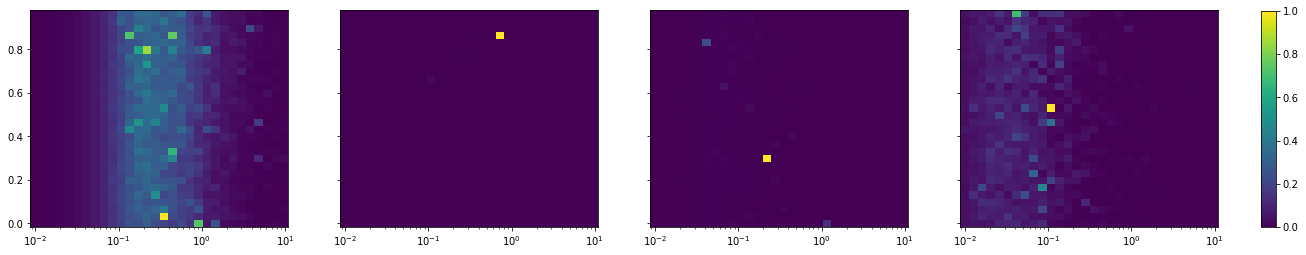

In [237]:
δ_grid_prelim, α_grid_prelim = np.meshgrid(δs_prelim, αs_prelim)
normalize = lambda a: a / np.nanmax(a)
fig, ax = plt.subplots(ncols=len(ϵs_prelim), figsize=(20, 4), sharey=True, sharex=True)

def normalize_without_maximum(a):
    a_copy = deepcopy(a)
    a_copy[np.unravel_index(np.argmax(a_copy), (N_GRID,N_GRID))] = np.nan
    return normalize(a_copy)

for i in range(len(ϵs_prelim)):
    SOME = normalize(OUT_EJSD_PRELIM[i, :, :]) #normalize_without_maximum(OUT_EJSD_PRELIM[i, :, :])
    im = ax[i].pcolor(δ_grid_prelim, α_grid_prelim, SOME) #normalize(OUT_EJSD_PRELIM[i, :, :]))
    ax[i].set_xscale('log')

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.98, 0.125, 0.01, 0.75])
fig.colorbar(im, cax=cbar_ax)
plt.show()

# Tables

In [127]:
# Settings
ϵ = 0.00001
δ = 0.1
B = 10
N = 10000

ϵs = [ϵ]
δs = [δ]
αs = [0.0, 0.5, 0.9, 0.99]

In [128]:
OUTS = generate_output(
    ϵs=ϵs,
    αs=αs,
    δs=δs
)

In [129]:
for i in range(len(αs)):
    print(OUTS[i]['ACCEPTANCES'].mean()*100)

8.58
6.97
8.03
8.17


In [91]:
def percentage_in_interval(iterable, left, right):
    """Counts the number of elements in `iterable` that are contained in the 
    interval `[left, right]`."""
    array = np.array(iterable)
    flag = (left <= array) & (array <= right)
    return (len(array[flag]) / len(array)) * 100

def proportion_lessthan(iterable, value):
    """Proportion of elements in iterable that are less than value."""
    array = np.array(iterable)
    flag = array <= value
    return (sum(flag) / len(array))

def find_value_so_prop_Δℓ_larger_new(iterable, p):
    N = len(iterable)
    return np.sort(np.array(iterable))[int(np.floor(N*np.round(1-p, decimals=2)))]

def generate_Δℓ_table_new(outs, props):
    """This table only works on intervals of the type [L, infty)."""
    table = zeros((len(outs), len(props)))
    Ls = []
    for p_ix, p in enumerate(props):
        # Find value L so that a proportion p of samples have Δℓ larger than L
        L = find_value_so_prop_Δℓ_larger_new(outs[0]['Δℓ'], p)
        Ls.append(L)
        # Fill in the first row of the table
        table[0, p_ix] = percentage_in_interval(outs[0]['Δℓ'], L, np.inf) # should be p
        # Fill in the rest of the rows for other αs
        for α_ix in range(1, len(outs)):
            table[α_ix, p_ix] = percentage_in_interval(outs[α_ix]['Δℓ'], L, np.inf)
    return table, Ls

def generate_latex_table(table, Ls):
    """Generate table."""
    s  = r"\begin{table}[htp]"         + "\n"
    s += r"\begin{tabular}{l|llll}"    + "\n"
    s += r"& $\Delta\ell \geq {:.2f}$ & $\Delta\ell \geq {:.2f}$ & $\Delta\ell \geq {:.2f}$ & $\Delta\ell \geq {:.2f}$ \\ \hline".format(*Ls) + "\n"
    s += r"$\alpha = 0$    & {:.0f} & {:.0f} & {:.0f} & {:.0f} \\".format(*table[0, :]) + "\n"
    s += r"$\alpha = 0.5$  & {:.2f} & {:.2f} & {:.2f} & {:.2f} \\".format(*table[1, :]) + "\n"
    s += r"$\alpha = 0.9$  & {:.2f} & {:.2f} & {:.2f} & {:.2f} \\".format(*table[2, :]) + "\n"
    s += r"$\alpha = 0.99$ & {:.2f} & {:.2f} & {:.2f} & {:.2f}".format(*table[3, :]) + "\n"
    s += r"\end{tabular}" + "\n"
    s += r"\end{table}"
    print(s)

In [92]:
generate_latex_table(*generate_Δℓ_table_new(OUTS, [0.25, 0.5, 0.75, 0.9]))

\begin{table}[htp]
\begin{tabular}{l|llll}
& $\Delta\ell \geq 0.05$ & $\Delta\ell \geq -0.23$ & $\Delta\ell \geq -1.47$ & $\Delta\ell \geq -4.66$ \\ \hline
$\alpha = 0$    & 25 & 50 & 75 & 90 \\
$\alpha = 0.5$  & 26.58 & 54.03 & 79.98 & 92.69 \\
$\alpha = 0.9$  & 27.68 & 57.70 & 82.23 & 94.06 \\
$\alpha = 0.99$ & 26.46 & 58.05 & 82.29 & 93.61
\end{tabular}
\end{table}


In [86]:
### CAREFUL! NEED TO MAKE SURE STEP SIZE IS LARGE ENOUGH

61.56
62.370000000000005
61.72
61.480000000000004
